In [3]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import consts
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50
import preceding_events

In [7]:
inputevets_filtered = pd.read_csv("..\\filtered\\input_events_filtered_by_subject_id_and_medicine.csv")
chartevents_filtered = pd.read_csv("..\\filtered\\filtered_chartevents.csv")
icustays_filtered = pd.read_csv("..\\filtered\\filtered_icustays.csv")
patients_filtered = pd.read_csv("..\\filtered\\filtered_patients.csv")
procedureevents_filtered = pd.read_csv("..\\filtered\\filtered_procedureevents.csv")
labevents_filtered = pd.read_csv("..\\filtered\\filtered_labevents.csv")
transfers_filtered = pd.read_csv("..\\filtered\\filtered_transfers.csv")
itemid = pd.read_csv("..\\data\\icu\\d_items.csv")

In [64]:
# check BP events one hour before dose

In [65]:
tmp = inputevets_filtered[inputevets_filtered["subject_id"] == 19004463][["subject_id", "starttime", "endtime", "rate", "originalrate", "itemid_label", "statusdescription"]]
tmp

,subject_id,starttime,endtime,rate,originalrate,itemid_label,statusdescription
0,19004463,2177-02-05 22:32:00,2177-02-05 22:44:00,5.021887,5.00,Phenylephrine,ChangeDose/Rate
1,19004463,2177-02-06 01:53:00,2177-02-06 02:57:00,0.200909,0.20,Phenylephrine,Stopped
2,19004463,2177-02-04 16:00:00,2177-02-04 20:54:00,0.500277,0.50,Phenylephrine,ChangeDose/Rate
3,19004463,2177-02-04 20:54:00,2177-02-04 22:04:00,0.200111,0.20,Phenylephrine,Stopped
4,19004463,2177-02-05 23:34:00,2177-02-06 01:53:00,0.502189,0.50,Phenylephrine,ChangeDose/Rate
5,19004463,2177-02-05 22:44:00,2177-02-05 23:34:00,1.004377,1.00,Phenylephrine,ChangeDose/Rate
67124,19004463,2177-01-30 09:45:00,2177-01-30 11:03:00,0.180178,0.18,Norepinephrine,ChangeDose/Rate
67125,19004463,2177-01-30 11:03:00,2177-01-30 11:31:00,0.100076,0.10,Norepinephrine,Stopped
67126,19004463,2177-01-30 09:23:00,2177-01-30 09:45:00,0.200238,0.20,Norepinephrine,ChangeDose/Rate


In [21]:
p = inputevets_filtered[["stay_id","starttime","endtime", "rate", "statusdescription", "originalrate", "itemid_label"]].sort_values(by=["stay_id","starttime"])
p

,stay_id,starttime,endtime,rate,statusdescription,originalrate,itemid_label
298219,30001446,2186-04-12 05:36:00,2186-04-12 06:09:00,5.004316,ChangeDose/Rate,5.000000,Dopamine
298220,30001446,2186-04-12 06:09:00,2186-04-12 07:28:00,2.502158,ChangeDose/Rate,2.500000,Dopamine
298222,30001446,2186-04-12 07:28:00,2186-04-12 08:00:00,2.001391,ChangeDose/Rate,2.000000,Dopamine
298221,30001446,2186-04-12 08:00:00,2186-04-12 09:47:00,2.500884,Paused,2.500000,Dopamine
154097,30001446,2186-04-12 09:57:00,2186-04-12 10:53:00,0.040011,ChangeDose/Rate,0.040000,Norepinephrine
...,...,...,...,...,...,...,...
152282,39999230,2147-09-01 11:30:00,2147-09-01 13:00:00,0.159902,ChangeDose/Rate,0.160000,Norepinephrine
152291,39999230,2147-09-01 13:00:00,2147-09-01 16:44:00,0.100165,FinishedRunning,0.100138,Norepinephrine
152275,39999230,2147-09-01 16:44:00,2147-09-01 18:00:00,0.080032,ChangeDose/Rate,0.080000,Norepinephrine
152290,39999230,2147-09-01 18:00:00,2147-09-01 18:49:00,0.060015,ChangeDose/Rate,0.060000,Norepinephrine


In [37]:
# convert to datetimes:
p["starttime"] = pd.to_datetime(p["starttime"])
p["endtime"] = pd.to_datetime(p["endtime"])
# add to each row its previous:
p["prev_status"] = p["statusdescription"].shift(1)
p["prev_start_time"] = p["starttime"].shift(1)
p["prev_endtime"] = p["endtime"].shift(1)
p["prev_stay_id"] = p["stay_id"].shift(1)
p["prev_originalrate"] = p["originalrate"].shift(1)
p["prev_dose"] = p["itemid_label"].shift(1)
# delete rows that the preceding row is another stay id
p.loc[p["prev_stay_id"] != p["stay_id"], "prev_status"] = np.nan
#p.loc[((p["prev_status"] == "ChangeDose/Rate") | (p["prev_status"] == "FinishedRunning")) & (p["prev_stay_id"] == p["stay_id"]) , "prev_decision"] = p["prev_start_time"]
#p.loc[((p["prev_status"] == "Paused") |(p["prev_status"] == "Stopped")) & (p["prev_stay_id"] == p["stay_id"]), "prev_decision"] = p["prev_endtime"]
p["diff_to_prev"] = p["starttime"] - p["prev_endtime"] 

#p[(p["diff_to_prev"] == pd.Timedelta(0, unit="minute")) & (p["prev_originalrate"]) == p["originalrate"]]["statusdescription"]
p[((p["prev_originalrate"]) == p["originalrate"]) & ((p["prev_status"]) == "ChangeDose/Rate") & ((p["prev_dose"]) == p["itemid_label"])]["statusdescription"].value_counts()

Stopped            14
ChangeDose/Rate     6
FinishedRunning     2
Name: statusdescription, dtype: int64

In [117]:
tmp = inputevets_filtered[0:10000]

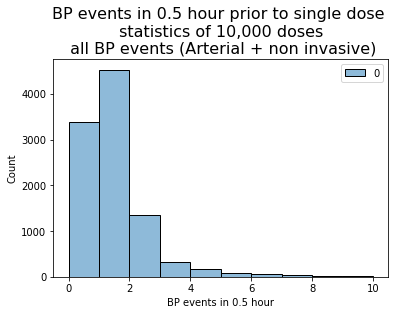

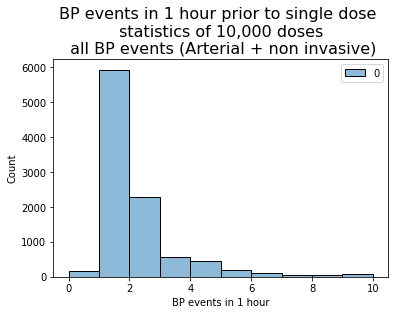

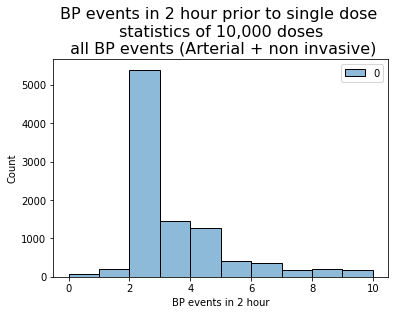

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
for period, color in zip([0.5, 1, 2],["red","blue", "orange"]):
    counts_lst = []
    for row in range(tmp.shape[0]):
        dose_preceding_results = preceding_events.get_events_beofore_dose(tmp.iloc[row]["starttime"], period, tmp.iloc[row]["subject_id"], chartevents_filtered, "charttime")
        results_count = dose_preceding_results[dose_preceding_results["itemid_label"] != "Heart Rate"].shape[0]
        counts_lst.append(results_count)
        
    sns.histplot(pd.DataFrame(counts_lst), binrange=[0,10], bins=10, color=color)
    plt.title(f"BP events in {str(period)} hour prior to single dose \n statistics of 10,000 doses \n all BP events (Arterial + non invasive)", fontsize=16)
    plt.xlabel(f"BP events in {str(period)} hour")
    plt.savefig(f"plots/BP_events_in_{str(period)}_hour_prior_to_dose.png")
    plt.show()

In [111]:
pd.DataFrame(counts_lst).value_counts(normalize=True) *100

1     39.9
0     29.0
2     18.9
3      5.0
4      2.4
5      1.3
7      1.0
6      0.9
8      0.5
9      0.4
18     0.2
20     0.2
21     0.2
25     0.1
dtype: float64

In [14]:
chartevents_filtered[(chartevents_filtered["stay_id"] == 39101627) & (chartevents_filtered["itemid_label"] == "Arterial Blood Pressure mean")]

,Unnamed: 0.1,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,itemid_label
2294611,2294611,11382715,19004463,24357541,39101627,2177-01-14 02:59:00,2177-01-14 03:31:00,220052,88.0,88.0,mmHg,0,Arterial Blood Pressure mean
2294612,2294612,11382719,19004463,24357541,39101627,2177-01-14 03:00:00,2177-01-14 03:31:00,220052,83.0,83.0,mmHg,0,Arterial Blood Pressure mean
2294613,2294613,11382750,19004463,24357541,39101627,2177-01-14 04:00:00,2177-01-14 04:07:00,220052,77.0,77.0,mmHg,0,Arterial Blood Pressure mean
2294614,2294614,11382786,19004463,24357541,39101627,2177-01-14 05:00:00,2177-01-14 05:06:00,220052,91.0,91.0,mmHg,0,Arterial Blood Pressure mean
2294615,2294615,11382811,19004463,24357541,39101627,2177-01-14 06:00:00,2177-01-14 06:06:00,220052,94.0,94.0,mmHg,0,Arterial Blood Pressure mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295279,2295279,11394672,19004463,24357541,39101627,2177-02-10 00:00:00,2177-02-10 00:42:00,220052,111.0,111.0,mmHg,0,Arterial Blood Pressure mean
2295280,2295280,11394713,19004463,24357541,39101627,2177-02-10 01:00:00,2177-02-10 01:21:00,220052,101.0,101.0,mmHg,0,Arterial Blood Pressure mean
2295281,2295281,11394719,19004463,24357541,39101627,2177-02-10 02:00:00,2177-02-10 02:36:00,220052,115.0,115.0,mmHg,0,Arterial Blood Pressure mean
2295282,2295282,11394728,19004463,24357541,39101627,2177-02-10 03:00:00,2177-02-10 03:33:00,220052,111.0,111.0,mmHg,0,Arterial Blood Pressure mean


In [41]:
preceding_events.get_events_beofore_dose(tmp.iloc[row]["starttime"], 1, tmp.iloc[row]["subject_id"], chartevents_filtered, "charttime")

,Unnamed: 0.1,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,itemid_label
269130,269130,11390253,19004463,24357541,39101627,2177-01-30 08:30:00,2177-01-30 09:22:00,220045,112.0,112.0,bpm,0,Heart Rate
269131,269131,11390259,19004463,24357541,39101627,2177-01-30 08:40:00,2177-01-30 09:22:00,220045,128.0,128.0,bpm,0,Heart Rate
269132,269132,11390265,19004463,24357541,39101627,2177-01-30 08:50:00,2177-01-30 09:22:00,220045,131.0,131.0,bpm,0,Heart Rate
269133,269133,11390271,19004463,24357541,39101627,2177-01-30 09:00:00,2177-01-30 09:22:00,220045,123.0,123.0,bpm,0,Heart Rate
269134,269134,11390296,19004463,24357541,39101627,2177-01-30 09:10:00,2177-01-30 09:22:00,220045,120.0,120.0,bpm,0,Heart Rate
269135,269135,11390302,19004463,24357541,39101627,2177-01-30 09:20:00,2177-01-30 09:22:00,220045,109.0,109.0,bpm,0,Heart Rate
2295003,2295003,11390256,19004463,24357541,39101627,2177-01-30 08:30:00,2177-01-30 09:22:00,220052,78.0,78.0,mmHg,0,Arterial Blood Pressure mean
2295004,2295004,11390262,19004463,24357541,39101627,2177-01-30 08:40:00,2177-01-30 09:22:00,220052,68.0,68.0,mmHg,0,Arterial Blood Pressure mean
2295005,2295005,11390268,19004463,24357541,39101627,2177-01-30 08:50:00,2177-01-30 09:22:00,220052,64.0,64.0,mmHg,0,Arterial Blood Pressure mean
2295006,2295006,11390274,19004463,24357541,39101627,2177-01-30 09:00:00,2177-01-30 09:22:00,220052,60.0,60.0,mmHg,0,Arterial Blood Pressure mean
